In [9]:
import random
import math
import kdtree
from statistics import mean
import pandas as pd
from tests.read_test_map import read_test_map
from visualization.map_visualization import show_map_vectorized
from visualization.rrt_visualization import visualize_rrt
from tests.check_results import construct_path_from_node
from utils.node import RRTNode
from shapely.geometry import Polygon as ShapelyPolygon, Point, LineString
from typing import List, Tuple, Union, Optional

![image.png](./media/tree.png)

# Sampling-Based алгоритм RRT для задачи поиска пути
В данной лабораторной работе мы изучим задачу поиска пути в непрерывном пространстве для агента-робота, используя подход на основе сэмплирования. Основной метод, который мы будем рассматривать, — это алгоритм Rapidly-exploring Random Tree (RRT), широко применяемый для планирования траекторий в сложных конфигурационных пространствах.

Алгоритм RRT опирается на построение специальной структуры данных — дерева, которое быстро охватывает область поиска за счет последовательного добавления новых узлов. Каждый узел дерева, за исключением корня, имеет ровно одного родителя. На каждом шаге алгоритм генерирует новый узел и пытается присоединить его к существующему дереву. Конечная цель заключается в том, чтобы достичь области, близкой к целевой точке, посредством последовательного расширения дерева.

Процесс расширения дерева RRT можно описать следующим образом:

1) **Генерация случайной точки:** выбрать случайную точку x<sub>rand</sub> пространстве.  
2) **Поиск ближайшего узла:** найти узел x<sub>near</sub> в текущем дереве, ближайший к точке x<sub>rand</sub> 
3) **Расширение дерева:** создать новый узел x<sub>new</sub> в направлении от точки x<sub>near</sub> к x<sub>rand</sub>.  

Преимущество алгоритмов RRT и других методов на основе сэмплинга заключается в их применимости для задач поиска пути в непрерывных пространствах с учетом различных ограничений — геометрических (например, форма и размеры агента) и кинематических (ограничения на скорость и ускорение). Эти методы особенно эффективны при решении задач высокой размерности, таких как планирование движений манипуляторов.

Однако в данной лабораторной работе мы сосредоточимся на ключевых идеях алгоритмов на основе сэмплинга, применяя их к задаче поиска пути на двумерной плоскости.

# Представление пространства

Для моделирования задачи поиска пути и построения дерева RRT в этой лабораторной работе используется двумерное пространство, в котором могут находиться препятствия, заданные в виде многоугольников.

## Описание препятствий

Препятствия определяются как наборы вершин многоугольников. Каждое препятствие представлено списком координат вершин в формате *(x, y)*. Например, список `obstacles_sample` содержит два препятствия:

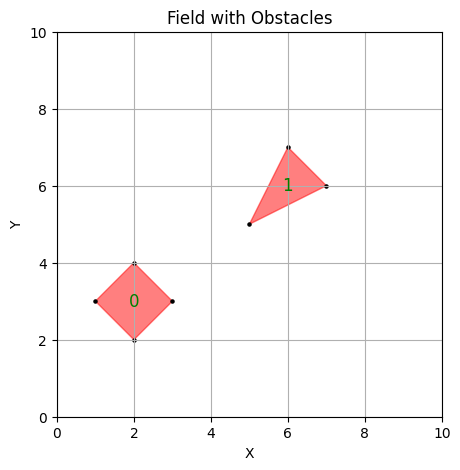

In [10]:
obstacles_sample = [[(2, 2), (3, 3), (2, 4), (1, 3)],
                    [(5, 5), (6, 7), (7, 6)],
                    ]

show_map_vectorized(10, 10, obstacles_sample, show_cords=False, show_obstacles_index=True, show_vertexes=True)


## RRTNode и KDTree
Алгоритм RRT строит дерево поиска, сэмплируя новые состояния и пытаясь соединить их с уже существующими узлами дерева. Одной из ключевых операций в процессе работы алгоритма является поиск ближайшего узла дерева к новому, только что сэмплированному состоянию. Эта операция будет выполняться многократно и желательно реализовать её эффективно.

Для реализации данной задачи мы будем использовать внешний модуль `kdtree`, который предоставляет структуру данных — [k-d-дерево](https://ru.wikipedia.org/wiki/K-d-дерево). K-d-дерево позволяет эффективно выполнять операции добавления элементов и поиска ближайших соседей с хорошей асимптотикой:

* Добавление элемента: **O(h)**  
* Поиск ближайшего соседа: **O(h) * (O(log(h)) + 1)**    

Где h — это высота дерева.
### Структура узлов дерева — RRTNode
Для заполнения дерева мы будем использовать объекты типа `RRTNode`. Каждый такой объект представляет собой узел дерева поиска, который хранит в себе следующую информацию:
* Координаты точки в пространстве (поле `state`)
* Ссылку на родительский узел (поле `parent`)
* Длина пути от корневого узла до текущего (поле `g`)

### Пример работы с RRTNode и KDTree
Для начала создадим корень дерева `RRTNode`, представляющий начальное состояние:

In [ ]:
help(RRTNode)

In [12]:
root_node = RRTNode(state=(0, 0), parent=None, g=0)  # Создание корня дерева
tree = kdtree.create([root_node])  # Создание дерева KDTree

Затем добавим в дерево несколько новых узлов:

In [13]:
cords = [(0, 1), (1, 2), (3, 5), (4, 2)]  # Набор координат новых узлов
for cord in cords:
    tree.add(RRTNode(state=cord, parent=root_node))  # Добавление новых вершин

Теперь можно найти ближайший узел к произвольной точке:

In [15]:
state_query = (2, 3)  # Состояние, для которого ищем ближайший узел
nearest_node = tree.search_nn(state_query)[0].data  # Поиск ближайшего узла
print("Ближайший узел:", nearest_node.state)

Ближайший узел: (1, 2)


In [ ]:
def in_collision(state: Tuple[float, float], obstacles) -> bool:
    """
    Проверяет, есть ли пересечение между заданным состоянием и препятствиями.

    Args:
        state: Координаты состояния (x, y).
        obstacles: Список препятствий.

    Return:
        bool: True, если состояние пересекается с каким-либо препятствием, иначе False.
    """
    # тут кажется была бага связанная с типом 
    point = Point(state)
    for obs in obstacles:
        if ShapelyPolygon(obs).contains(point):
            return True
    return False
    

def distance(state1: Tuple[float, float], state2: Tuple[float, float]) -> float:
    """
    Вычисляет расстояние между двумя состояниями в пространстве.

    В данной лабораторной работе используется евклидово расстояние между точками на плоскости.

    Args:
        state1: Координаты первого состояния.
        state2: Координаты второго состояния.

    Return:
        float: Евклидово расстояние между двумя состояниями.
    """
    return math.sqrt(abs(state1[0] - state2[0]) ** 2 + abs(state1[1] - state2[1]) ** 2)


def in_goal_region(state: Tuple[float, float], state_goal: Tuple[float, float], region_size: float) -> bool:
    """
    Проверяет, находится ли заданное состояние в пределах допустимого расстояния от целевого состояния.

    Args:
        state: Координаты проверяемого состояния.
        state_goal: Координаты целевого состояния.
        region_size: Радиус области, в пределах которой состояние считается достижением цели.

    Return:
        bool: True, если состояние находится в пределах области цели, иначе False.
    """
    return distance(state, state_goal) <= region_size
    

def is_trajectory_clear(start_state: Tuple[float, float], end_state: Tuple[float, float], obstacles: List[ShapelyPolygon]) -> bool:
    """
    Проверяет, пересекает ли траектория, задаваемая начальным и конечным состояниями, какие-либо препятствия.

    Args:
        start_state: Координаты начального состояния.
        end_state: Координаты конечного состояния.
        obstacles: Список препятствий.

    Return:
        bool: True, если траектория свободна от пересечений, иначе False.
    """
    for obs in obstacles:
        if LineString([start_state, end_state]).intersects(ShapelyPolygon(obs)):
            return False
    return True


def create_random_state(map_width: float, map_height: float, 
                        goal_bias: float, goal_state: Tuple[float, float], 
                        goal_sampling_region: float) -> Tuple[float, float]:
    """
    Генерирует случайное состояние в пространстве поиска.

    С вероятностью `goal_bias` возвращает состояние в окрестности цели в пределах размера области `goal_sampling_region` 
    (любое, можно саму цель всегда возвращать). 
    В противном случае генерирует равномерно случайное состояние в пределах карты.

    Args:
        map_width: Ширина карты.
        map_height: Высота карты.
        goal_bias: Вероятность генерации состояния около цели.
        goal_state: Координаты целевого состояния.
        goal_sampling_region: Размер области около цели.

    Return:
        tuple[float, float]: Случайное состояние (x, y).
    """
    if random.random() < goal_bias:
        # здесь возвращается в пределах кварата а не круга... хз какой вариант нужен был
        offset_x = random.uniform(-goal_sampling_region, goal_sampling_region)
        offset_y = random.uniform(-goal_sampling_region, goal_sampling_region)
        
        x = goal_state[0] + offset_x
        y = goal_state[1] + offset_y
        
        x = max(0, min(map_width, x))
        y = max(0, min(map_height, y))

        return (x, y)
    else:
        x = random.uniform(0, map_width)
        y = random.uniform(0, map_height)
        return (x, y)


def find_nearest_neighbour(tree: kdtree, state_random: Tuple[float, float]) -> RRTNode:
    """
    Находит ближайший узел в дереве поиска к заданному случайному состоянию.

    Args:
        tree: KD-дерево, представляющее текущее дерево поиска.
        state_random: Случайно сгенерированное состояние.

    Return:
        RRTNode: Ближайший узел в дереве к заданному состоянию.
    """
    return tree.search_nn(state_random)[0].data  


def extend(tree: kdtree, obstacles: List[ShapelyPolygon], 
           state_random: Tuple[float, float], 
           max_transition: float) -> Tuple[bool, Optional[RRTNode]]:
    """
    Расширяет дерево поиска, пытаясь создать новое состояние в направлении заданного случайного состояния
    (проверяется точка, находящаяся на расстоянии минимума из расстояния до ближайшего соседа и `max_transition`).

    Если новое состояние валидно и не пересекается с препятствиями, оно добавляется в дерево.

    Args:
        tree: KD-дерево, представляющее текущее дерево поиска.
        obstacles: Список препятствий в пространстве.
        state_random: Случайно сгенерированное состояние.
        max_transition: Максимально допустимое расстояние перехода.

    Return:
        tuple[bool, Optional[RRTNode]]: 
            - Флаг успешного добавления нового состояния.
            - Новый узел, если состояние было добавлено, иначе None.

    ! Не забудьте при составлении RRTNode указать его родителя и стоимость перехода в него
    """
    nearest_node = find_nearest_neighbour(tree, state_random)
    nearest_state = nearest_node.state
    needed_distance = min(max_transition, distance(nearest_node.state, state_random))
    
    if needed_distance > 0: 
        direction_x = (state_random[0] - nearest_node.state[0]) / needed_distance
        direction_y = (state_random[1] - nearest_node.state[1]) / needed_distance

        new_state = (
            nearest_node.state[0] + direction_x * needed_distance,
            nearest_node.state[1] + direction_y * needed_distance
        )
    else:
        # если они совпали то добавлять ничего не надо  
        return (False, None)
    
    # если она в препятсвии 
    if in_collision(new_state, obstacles):
        return (False, None)

    # если есть припятсвие по пути
    if not is_trajectory_clear(nearest_node.state, new_state, obstacles):
        return (False, None)
    
    # добавляем в дерево если все оки 
    new_g = nearest_node.g + distance(nearest_node.state, new_state)
    new_node = RRTNode(new_state, nearest_node, new_g)
    tree.add(new_node)

    return (True, new_node)


## Основной алгоритм RRT

Функция `rrt` собирает вместе весь функционал алгоритма поиска пути. На каждом шаге алгоритм выполняет следующие действия:

1. Генерирует случайное состояние с помощью `create_random_state`.

2. Расширяет дерево с помощью функции `extend`. 

3. Проверяет, достиг ли алгоритм целевой области.

Если цель достигнута или превышено максимальное количество итераций, функция завершает свою работу.


Обратите внимание! Сохраняйте все добавленные узлы в список `all_points`, чтобы впоследствии визуализировать процесс построения дерева.
Также не забывайте пополнять ими дерево через `tree.add(...)`

In [ ]:
def rrt(map_w: int,
        map_h: int,
        obstacles: List[List[float]], 
        start_x: float, 
        start_y: float, 
        goal_x: float, 
        goal_y: float, 
        max_transition: float,
        max_iter: int = 3000, 
        goal_region: float = 5,
        goal_bias: float = 0.05
        ) -> Tuple[bool, Optional['RRTNode'], int, Optional['kdtree.KDTree'], List[Tuple['RRTNode', int]]]:
    """
    Реализует алгоритм поиска RRT.

    Args:
        map_w: Ширина карты.
        map_h: Высота карты.
        obstacles: Список препятствий на карте.
        start_x: Координата x начальной точки.
        start_y: Координата y начальной точки.
        goal_x: Координата x цели.
        goal_y: Координата y цели.
        max_transition: Максимальное расстояние, на которое может перемещаться агент за один шаг.
        max_iter: Максимальное количество итераций алгоритма.
        goal_region: Размер окрестности целевого состояния, в которой цель считается достигнутой.
        goal_bias: Вероятность сэмплинга состояния, близкого к цели.

    Returns:
        Tuple[bool, Optional[RRTNode], int, Optional[kdtree.KDTree], List[RRTNode]]:
            - Булевое значение, указывающее, был ли найден путь.
            - Последний узел найденного пути или None, если путь не был найден.
            - Количество итераций, выполненных алгоритмом.
            - KD-дерево, представляющее дерево поиска, или None, если путь не найден.
            - Список всех узлов, добавленных в дерево, в порядке добавления, а также итерация на которой узел был добавлен
    """
    
    node_start = RRTNode([start_x, start_y], None, 0.0)
    state_goal = [goal_x, goal_y]
    tree = kdtree.create([node_start])
    iter = 0
    all_points = [(node_start, 0)] # тут хранятся пары из вершин (RRTNode) и номера итерации на котором их добавили
    
    for iter in range(1, max_iter + 1):

        # генерируем рандом состяние 
        state_random = create_random_state(
            map_w, map_h, goal_bias, state_goal, goal_region
        )

        # пытаемсяя добавить ноду в дерево
        correct, new_node = extend(
            tree, obstacles, state_random, max_transition
        )

        if not correct:
            continue

        all_points.append((new_node, iter))

        # проверяем добавленную ноду на попадание
        if in_goal_region(new_node.state, state_goal, goal_region):
            return (True, new_node, iter, tree, all_points)
        
    return (False, None, max_iter, tree, all_points)

# Тесты

<img src="./media/maps.png" alt="drawing" width="700"/>

## Small test
Предварительный тест для проверки всё ли у вас правильно работает

In [49]:
width, height, start, goal, obstacles = read_test_map("./tests/columns_small.txt")
found, end_node, number_of_steps, tree, all_points = rrt(width, height, obstacles, *start, *goal, max_transition=5, goal_bias=0.05, goal_region=5)
assert found, "`found` должно быть True - иначе пробуйте ещё раз или что-то реализовано неверно"

In [ ]:
animation = visualize_rrt(width, height, *start, *goal, obstacles, all_points, construct_path_from_node(end_node), goal_region=5, iterations=number_of_steps, max_iteration=1000, path_length=42)
animation

# Columns

In [51]:
width, height, start, goal, obstacles = read_test_map("./tests/columns.txt")
found, end_node, number_of_steps, tree, all_points = rrt(width, height, obstacles, *start, *goal, max_transition=7, goal_bias=0.05, goal_region=10)
assert found, "`found` должно быть True - иначе пробуйте ещё раз или что-то реализовано неверно"

In [ ]:
animation = visualize_rrt(width, height, *start, *goal, obstacles, all_points, construct_path_from_node(end_node), goal_region=10, iterations=number_of_steps, max_iteration=10_000, path_length=end_node.g)
animation

## Random Obstacles 

In [53]:
width, height, start, goal, obstacles = read_test_map("./tests/rand_polygons.txt")
found, end_node, number_of_steps, tree, all_points = rrt(width, height, obstacles, *start, *goal, max_transition=7, goal_bias=0.05, goal_region=10)
assert found, "`found` должно быть True - иначе пробуйте ещё раз или что-то реализовано неверно"

In [ ]:
animation = visualize_rrt(width, height, *start, *goal, obstacles, all_points, construct_path_from_node(end_node), goal_region=10, iterations=number_of_steps, max_iteration=10_000, path_length=round(end_node.g,2))
animation

## Massive Tests

In [55]:
max_transitions = [3, 7, 15]
goal_regions = [5, 10, 25]
goal_biases = [0.05, 0.10, 0.15]

In [56]:

max_transitions = [3, 7, 15]
goal_regions = [5, 10, 25]
goal_biases = [0.05, 0.10, 0.15]
num_runs = 5 

width, height, start, goal, obstacles = read_test_map("./tests/columns_small.txt")
results = []

for max_transition in max_transitions:
    for goal_region in goal_regions:
        for goal_bias in goal_biases:
            run_results = []
            for _ in range(num_runs):
                found, end_node, number_of_steps, tree, all_points = rrt(
                    width, height, obstacles, *start, *goal, 
                    max_transition=max_transition, goal_bias=goal_bias, goal_region=goal_region
                )
                run_results.append({"found": found, 
                                    "number_of_steps": number_of_steps, 
                                    "number_of_nodes": len(all_points)})

            first_run = run_results[0]

            avg_steps = mean(run["number_of_steps"] for run in run_results)
            avg_nodes = mean(run["number_of_nodes"] for run in run_results)
            success_rate = sum(run["found"] for run in run_results) / num_runs

            results.append({
                "max_transition": max_transition,
                "goal_bias": goal_bias,
                "goal_region": goal_region,
                "first_run_found": first_run["found"],
                "first_run_steps": first_run["number_of_steps"],
                "first_run_nodes": first_run["number_of_nodes"],
                "avg_steps": avg_steps,
                "avg_nodes": avg_nodes,
                "success_rate": success_rate
            })
            line = results[-1]
            print("-----------------")
            print(f"Max transition: {line['max_transition']}")
            print(f"Goal bias: {line['goal_bias']}")
            print(f"Goal region: {line['goal_region']}")
            print(f"First run - Found: {line['first_run_found']}, Steps: {line['first_run_steps']}, Nodes: {line['first_run_nodes']}")
            print(f"Avg steps: {line['avg_steps']}")
            print(f"Avg nodes: {line['avg_nodes']}")
            print(f"Success rate: {line['success_rate']:.2f}")

df = pd.DataFrame(results)
print(df.to_string(index=False))

-----------------
Max transition: 3
Goal bias: 0.05
Goal region: 5
First run - Found: True, Steps: 116, Nodes: 49
Avg steps: 193
Avg nodes: 88.2
Success rate: 1.00
-----------------
Max transition: 3
Goal bias: 0.1
Goal region: 5
First run - Found: True, Steps: 136, Nodes: 48
Avg steps: 184.2
Avg nodes: 73
Success rate: 1.00
-----------------
Max transition: 3
Goal bias: 0.15
Goal region: 5
First run - Found: True, Steps: 16, Nodes: 10
Avg steps: 146.6
Avg nodes: 48
Success rate: 1.00
-----------------
Max transition: 3
Goal bias: 0.05
Goal region: 10
First run - Found: True, Steps: 503, Nodes: 223
Avg steps: 298.6
Avg nodes: 125.2
Success rate: 1.00
-----------------
Max transition: 3
Goal bias: 0.1
Goal region: 10
First run - Found: True, Steps: 218, Nodes: 85
Avg steps: 169.6
Avg nodes: 65.4
Success rate: 1.00
-----------------
Max transition: 3
Goal bias: 0.15
Goal region: 10
First run - Found: True, Steps: 369, Nodes: 126
Avg steps: 276
Avg nodes: 98
Success rate: 1.00
-----------